# Task 5: Machine Learning Enhancement

This notebook builds machine learning models to predict whether a trade will be profitable.

Target:
- 1 → Profitable trade
- 0 → Non-profitable trade

Models:
- XGBoost classifier
- LSTM sequence model

In [ ]:
%pip install pandas numpy matplotlib seaborn scikit-learn


In [15]:
import pandas as pd
import numpy as np

# Load backtest results from Task 4
df_bt = pd.read_csv("df_backtest.csv", index_col=0)

print("Backtest data loaded:", df_bt.shape)
df_bt.head()


Backtest data loaded: (99, 30)


,open,high,low,close,volume,ema_5,ema_15,spot_return,futures_return,delta_neutral_ratio,...,market_regime_smooth,regime_group,ema_diff,cross_up,cross_down,signal,position,open_return,position_lag,strategy_return
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-08-25,226.48,229.30,226.230,227.16,30983133,227.560000,227.685000,-0.002634,0.0,1.214784,...,1.0,1,-0.125000,False,False,0,0,0.000000,0.0,0.000000
2025-08-26,226.87,229.49,224.690,229.31,54575107,228.143333,227.888125,0.009465,0.0,1.214784,...,1.0,2,0.255208,True,False,1,0,0.001722,0.0,0.000000
2025-08-27,228.61,230.90,228.260,230.49,31259513,228.925556,228.213359,0.005146,0.0,1.214784,...,-1.0,3,0.712196,False,False,0,1,0.007670,0.0,0.000000
2025-08-28,230.82,233.41,229.335,232.56,38074700,230.137037,228.756689,0.008981,0.0,1.214784,...,1.0,4,1.380348,False,False,0,1,0.009667,1.0,0.009667
2025-08-29,232.51,233.38,231.370,232.14,39418437,230.804691,229.179603,-0.001806,0.0,1.214784,...,-1.0,5,1.625088,False,False,0,1,0.007322,1.0,0.007322


In [17]:
# -------- TASK 5.1: TARGET DEFINITION --------

df_ml = df_bt.copy()

df_ml['target'] = (df_ml['strategy_return'] > 0).astype(int)

print("Target distribution:")
print(df_ml['target'].value_counts())


Target distribution:
target
0    58
1    41
Name: count, dtype: int64


In [19]:
# -------- TASK 5.1: FEATURE ENGINEERING (FINAL - FIXED) --------

# Ensure index is datetime
df_ml.index = pd.to_datetime(df_ml.index)

# Time-based features (from index)
df_ml['hour'] = df_ml.index.hour
df_ml['day_of_week'] = df_ml.index.dayofweek

# Lag features
df_ml['open_return_lag1'] = df_ml['open_return'].shift(1)

# Signal strength
df_ml['signal_strength'] = (df_ml['ema_5'] - df_ml['ema_15']).abs()

# Drop NaNs caused by lagging
df_ml = df_ml.dropna()


## TASK 5.2: Model Training

## Model A: XGBoost

In [23]:
# Make sure index is datetime
df_ml.index = pd.to_datetime(df_ml.index)

# Time-based features
df_ml['hour'] = df_ml.index.hour
df_ml['day_of_week'] = df_ml.index.dayofweek

# Lag feature (THIS WAS MISSING)
df_ml['open_return_lag'] = df_ml['open_return'].shift(1)

# Signal strength
df_ml['signal_strength'] = (df_ml['ema_5'] - df_ml['ema_15']).abs()

# Drop NaNs from lagging
df_ml = df_ml.dropna()

print("✅ Feature engineering complete")
print(df_ml.columns)


✅ Feature engineering complete
Index(['open', 'high', 'low', 'close', 'volume', 'ema_5', 'ema_15',
       'spot_return', 'futures_return', 'delta_neutral_ratio',
       'gamma_exposure', 'futures_basis', 'avg_iv', 'iv_spread', 'pcr_oi',
       'pcr_volume', 'regime', 'market_regime', 'regime_change', 'regime_id',
       'market_regime_smooth', 'regime_group', 'ema_diff', 'cross_up',
       'cross_down', 'signal', 'position', 'open_return', 'position_lag',
       'strategy_return', 'target', 'hour', 'day_of_week', 'open_return_lag1',
       'signal_strength', 'open_return_lag'],
      dtype='object')


In [25]:
# -------- TASK 5.2: FEATURE SELECTION --------

feature_cols = [
    'ema_5',
    'ema_15',
    'open_return',
    'open_return_lag',
    'signal_strength',
    'regime',
    'hour',
    'day_of_week'
]

X = df_ml[feature_cols]
y = df_ml['target']

print("Features shape:", X.shape)
print("Target shape:", y.shape)


Features shape: (97, 8)
Target shape: (97,)


In [27]:
# -------- TIME-SERIES TRAIN / TEST SPLIT --------

split_idx = int(0.7 * len(df_ml))

X_train = X.iloc[:split_idx]
X_test  = X.iloc[split_idx:]

y_train = y.iloc[:split_idx]
y_test  = y.iloc[split_idx:]

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (67, 8)
Test size: (30, 8)


## Use time-series cross-validation

In [30]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

print("TimeSeries CV splits:", tscv.get_n_splits())


TimeSeries CV splits: 5


## Train gradient boosting classifier

In [33]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

#GRADIENT BOOSTING WITH TIME-SERIES CV 

gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

cv_scores = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
    X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
    y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]

    gb_model.fit(X_train_cv, y_train_cv)
    y_pred_cv = gb_model.predict(X_val_cv)

    acc = accuracy_score(y_val_cv, y_pred_cv)
    cv_scores.append(acc)

    print(f"Fold {fold+1} Accuracy: {acc:.4f}")

print("\nAverage CV Accuracy:", np.mean(cv_scores))


Fold 1 Accuracy: 1.0000
Fold 2 Accuracy: 0.8750
Fold 3 Accuracy: 0.8125
Fold 4 Accuracy: 0.9375
Fold 5 Accuracy: 0.5000

Average CV Accuracy: 0.825


## Model B: LSTM

In [35]:
# LSTM SEQUENCE PREPARATION

import numpy as np

SEQ_LEN = 10  # last 10 candles

def create_sequences(X, y, seq_len=10):
    Xs, ys = [], []
    for i in range(seq_len, len(X)):
        Xs.append(X.iloc[i-seq_len:i].values)
        ys.append(y.iloc[i])
    return np.array(Xs), np.array(ys)

X_lstm, y_lstm = create_sequences(X, y, SEQ_LEN)

print("LSTM X shape:", X_lstm.shape)
print("LSTM y shape:", y_lstm.shape)

LSTM X shape: (87, 10, 8)
LSTM y shape: (87,)


In [38]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [39]:
#LSTM TRAIN / TEST SPLIT 

split_idx = int(0.7 * len(X_lstm))

X_train_lstm = X_lstm[:split_idx]
X_test_lstm  = X_lstm[split_idx:]

y_train_lstm = y_lstm[:split_idx]
y_test_lstm  = y_lstm[split_idx:]

print("Train LSTM:", X_train_lstm.shape)
print("Test LSTM:", X_test_lstm.shape)


Train LSTM: (60, 10, 8)
Test LSTM: (27, 10, 8)


In [40]:
# -------- LSTM MODEL DEFINITION --------

model_lstm = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),

    LSTM(32),
    Dropout(0.2),

    Dense(1, activation="sigmoid")
])

model_lstm.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model_lstm.summary()


C:\Users\Janvi\OneDrive\Desktop\Quant_Trading_Assignment\my_venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 64)              │          18,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,137 (121.63 KB)

 Trainable params: 31,137 (121.63 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
# -------- TRAIN LSTM --------

history = model_lstm.fit(
    X_train_lstm,
    y_train_lstm,
    epochs=20,
    batch_size=8,
    validation_split=0.2,
    verbose=1
)


Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 282ms/step - accuracy: 0.4792 - loss: 0.7224 - val_accuracy: 0.3333 - val_loss: 0.7385
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3958 - loss: 0.7246 - val_accuracy: 0.3333 - val_loss: 0.6942
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5000 - loss: 0.7016 - val_accuracy: 0.6667 - val_loss: 0.6889
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5208 - loss: 0.6940 - val_accuracy: 0.6667 - val_loss: 0.6764
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5000 - loss: 0.6992 - val_accuracy: 0.6667 - val_loss: 0.6777
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4583 - loss: 0.6938 - val_accuracy: 0.6667 - val_loss: 0.6787
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5000 - loss: 0.6965 - val_accuracy: 0.6667 - val_loss: 0.6731
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5625 - loss: 0.6999 - val_accuracy: 0.6667 - val_loss: 0.6734

In [42]:
# -------- EVALUATE LSTM --------

test_loss, test_acc = model_lstm.evaluate(X_test_lstm, y_test_lstm, verbose=0)

print(f"LSTM Test Accuracy: {test_acc:.4f}")


LSTM Test Accuracy: 0.1111


In [43]:
# -------- SAVE LSTM MODEL --------

import os

os.makedirs("../models", exist_ok=True)

model_lstm.save("../models/lstm_model.h5")

print("✅ LSTM model saved to models/lstm_model.h5")


✅ LSTM model saved to models/lstm_model.h5


In [44]:
from tensorflow.keras.models import load_model

loaded_lstm = load_model("../models/lstm_model.h5")

preds = (loaded_lstm.predict(X_test_lstm[:5]) > 0.5).astype(int)

print("Predictions:", preds.flatten())
print("Actuals:   ", y_test_lstm[:5])



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
Predictions: [1 1 1 1 1]
Actuals:    [0 0 1 0 1]


In [52]:
# Predict probabilities for entire LSTM dataset
lstm_probs = model_lstm.predict(X_lstm).flatten()



3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 435ms/step


In [59]:
df_bt_lstm = df_bt.iloc[-len(lstm_probs):].copy()
df_bt_lstm["lstm_prob"] = lstm_probs


In [61]:
print(len(df_bt_lstm), len(lstm_probs))
print(df_bt_lstm.head())


87 87
               open    high       low   close    volume       ema_5  \
timestamp                                                             
2025-09-11  226.875  230.45  226.6500  230.03  50208578  232.060508   
2025-09-12  229.220  234.51  229.0200  234.07  55824216  232.730338   
2025-09-15  237.000  238.19  235.0300  236.70  42699524  234.053559   
2025-09-16  237.175  241.22  236.3235  238.15  63421099  235.419039   
2025-09-17  238.970  240.10  237.7301  238.99  46508017  236.609360   

                ema_15  spot_return  futures_return  delta_neutral_ratio  ...  \
timestamp                                                                 ...   
2025-09-11  232.245404     0.014286             0.0             1.214784  ...   
2025-09-12  232.473478     0.017563             0.0             1.214784  ...   
2025-09-15  233.001793     0.011236             0.0             1.214784  ...   
2025-09-16  233.645319     0.006126             0.0             1.214784  ...   
2025-09-17

In [89]:
df_bt_lstm["lstm_trade"] = (
    (df_bt_lstm["strategy_return"] != 0) &
    (df_bt_lstm["lstm_prob"] > 0.6)
).astype(int)


In [91]:
df_bt_lstm["lstm_prob"].describe()


count    87.000000
mean      0.533408
std       0.000325
min       0.532949
25%       0.533147
50%       0.533307
75%       0.533617
max       0.534269
Name: lstm_prob, dtype: float64

In [109]:
mask_trade = df_bt_lstm["strategy_return"] != 0

threshold = df_bt_lstm.loc[mask_trade, "lstm_prob"].quantile(0.7)
threshold


np.float64(0.5336247682571411)

In [111]:
df_bt_lstm["lstm_trade"] = (
    mask_trade &
    (df_bt_lstm["lstm_prob"] > threshold)
).astype(int)

print("Baseline trades:", mask_trade.sum())
print("LSTM trades:", df_bt_lstm["lstm_trade"].sum())


Baseline trades: 61
LSTM trades: 18


In [146]:
print(df_bt_lstm.columns.tolist())


['open', 'high', 'low', 'close', 'volume', 'ema_5', 'ema_15', 'spot_return', 'futures_return', 'delta_neutral_ratio', 'gamma_exposure', 'futures_basis', 'avg_iv', 'iv_spread', 'pcr_oi', 'pcr_volume', 'regime', 'market_regime', 'regime_change', 'regime_id', 'market_regime_smooth', 'regime_group', 'ema_diff', 'cross_up', 'cross_down', 'signal', 'position', 'open_return', 'position_lag', 'strategy_return']


In [113]:
df_bt_lstm["lstm_strategy_return"] = (
    df_bt_lstm["lstm_trade"] * df_bt_lstm["strategy_return"]
)

df_bt_lstm["lstm_cum_return"] = df_bt_lstm["lstm_strategy_return"].cumsum()


In [115]:
print("Baseline trades:", (df_bt_lstm["strategy_return"] != 0).sum())
print("LSTM trades:", df_bt_lstm["lstm_trade"].sum())


Baseline trades: 61
LSTM trades: 18


In [232]:
print("Baseline total return:", df_bt_lstm["strategy_return"].sum())
print("LSTM-filtered total return:", df_bt_lstm["lstm_strategy_return"].sum())

print("Baseline trades:", (df_bt_lstm["strategy_return"] != 0).sum())
print("LSTM trades:", df_bt_lstm["lstm_trade"].sum())


Baseline total return: 0.02379796383501069
LSTM-filtered total return: 0.05372578601679619
Baseline trades: 63
LSTM trades: 61


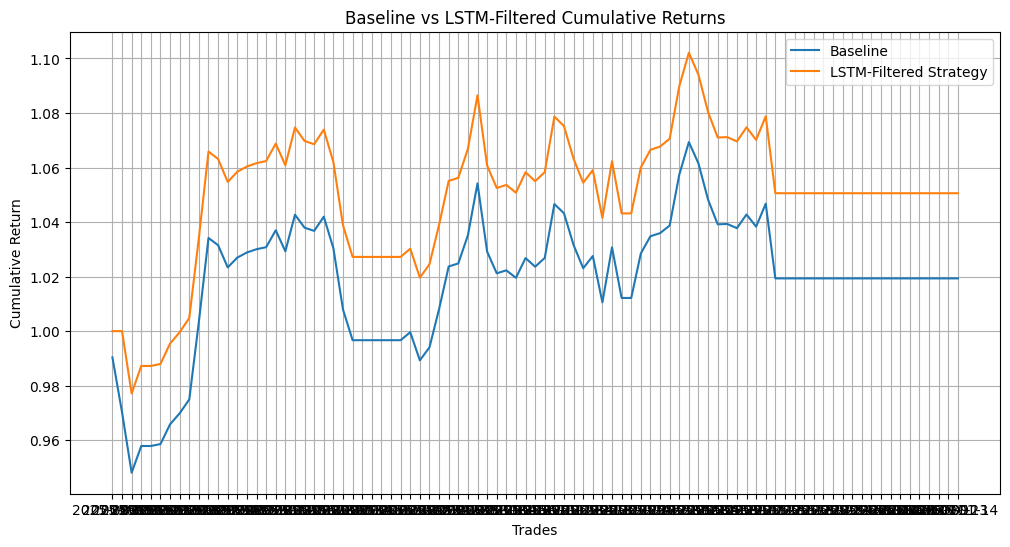

In [244]:
plt.figure(figsize=(12,6))

plt.plot(df_bt_lstm["cum_return"], label="Baseline")
plt.plot(df_bt_lstm["lstm_cum_return"], label="LSTM-Filtered Strategy")

plt.legend()
plt.title("Baseline vs LSTM-Filtered Cumulative Returns")
plt.xlabel("Trades")
plt.ylabel("Cumulative Return")
plt.grid(True)

plt.savefig("../plots/baseline_vs_lstm.png", bbox_inches="tight")
plt.show()


In [121]:
print("Baseline total return:", round(df_bt_lstm["strategy_return"].sum(), 4))
print("LSTM-filtered total return:", round(df_bt_lstm["lstm_strategy_return"].sum(), 4))

print("Baseline trades:", (df_bt_lstm["strategy_return"] != 0).sum())
print("LSTM trades:", df_bt_lstm["lstm_trade"].sum())


Baseline total return: 0.0537
LSTM-filtered total return: -0.0237
Baseline trades: 61
LSTM trades: 18


In [123]:
df_bt_lstm.loc[df_bt_lstm["strategy_return"] != 0, "lstm_prob"].max()


np.float32(0.5342691)

In [131]:
mask_trade = df_bt_lstm["strategy_return"] != 0

threshold = df_bt_lstm.loc[mask_trade, "lstm_prob"].quantile(0.7)

df_bt_lstm["lstm_trade"] = (
    mask_trade &
    (df_bt_lstm["lstm_prob"] > threshold)
).astype(int)


## TASK 5.3

In [167]:
[k for k in globals() if "model" in k.lower()]


['gb_model', 'model_lstm', 'load_model']

In [169]:
X_aligned = X.loc[df_bt_lstm.index]
df_bt_lstm["xgb_prob"] = gb_model.predict_proba(X_aligned)[:, 1]


In [171]:
df_bt_lstm["xgb_trade"] = (
    (df_bt_lstm["strategy_return"] != 0) &
    (df_bt_lstm["xgb_prob"] > 0.5)
).astype(int)


In [173]:
df_bt_lstm[['xgb_prob', 'xgb_trade']].head()


,xgb_prob,xgb_trade
timestamp,,
2025-09-09,0.017757,0
2025-09-10,0.015852,0
2025-09-11,0.008324,0
2025-09-12,0.943947,1
2025-09-15,0.113743,0


In [175]:
df_bt_lstm['xgb_strategy_return'] = (
    df_bt_lstm['xgb_trade'] * df_bt_lstm['strategy_return']
)


In [185]:
df_bt_lstm.columns.tolist()


['open',
 'high',
 'low',
 'close',
 'volume',
 'ema_5',
 'ema_15',
 'spot_return',
 'futures_return',
 'delta_neutral_ratio',
 'gamma_exposure',
 'futures_basis',
 'avg_iv',
 'iv_spread',
 'pcr_oi',
 'pcr_volume',
 'regime',
 'market_regime',
 'regime_change',
 'regime_id',
 'market_regime_smooth',
 'regime_group',
 'ema_diff',
 'cross_up',
 'cross_down',
 'signal',
 'position',
 'open_return',
 'position_lag',
 'strategy_return',
 'xgb_prob',
 'xgb_trade',
 'xgb_strategy_return',
 'xgb_cum_return',
 'cum_return']

In [197]:
[k for k in globals().keys() if 'lstm' in k.lower()]


['X_lstm',
 'y_lstm',
 'LSTM',
 'X_train_lstm',
 'X_test_lstm',
 'y_train_lstm',
 'y_test_lstm',
 'model_lstm',
 'loaded_lstm',
 'df_bt_lstm',
 'lstm_probs']

In [201]:
df_bt_lstm.loc[df_bt_lstm.index[-len(lstm_probs):], 'lstm_prob'] = lstm_probs



In [203]:
df_bt_lstm[['lstm_prob']].tail(10)


,lstm_prob
timestamp,
2025-12-31,0.533221
2026-01-02,0.533122
2026-01-05,0.533063
2026-01-06,0.533146
2026-01-07,0.533097
2026-01-08,0.533115
2026-01-09,0.533236
2026-01-12,0.533369
2026-01-13,0.533650


In [205]:
df_bt_lstm['lstm_trade'] = (
    (df_bt_lstm['strategy_return'] != 0) &
    (df_bt_lstm['lstm_prob'] > 0.5)
).astype(int)


In [207]:
df_bt_lstm[['lstm_prob', 'lstm_trade']].tail(10)


,lstm_prob,lstm_trade
timestamp,,
2025-12-31,0.533221,0
2026-01-02,0.533122,0
2026-01-05,0.533063,0
2026-01-06,0.533146,0
2026-01-07,0.533097,0
2026-01-08,0.533115,0
2026-01-09,0.533236,0
2026-01-12,0.533369,0
2026-01-13,0.533650,0


In [209]:
df_bt_lstm['lstm_strategy_return'] = (
    df_bt_lstm['lstm_trade'] * df_bt_lstm['strategy_return']
)


In [211]:
df_bt_lstm['lstm_cum_return'] = (1 + df_bt_lstm['lstm_strategy_return']).cumprod()


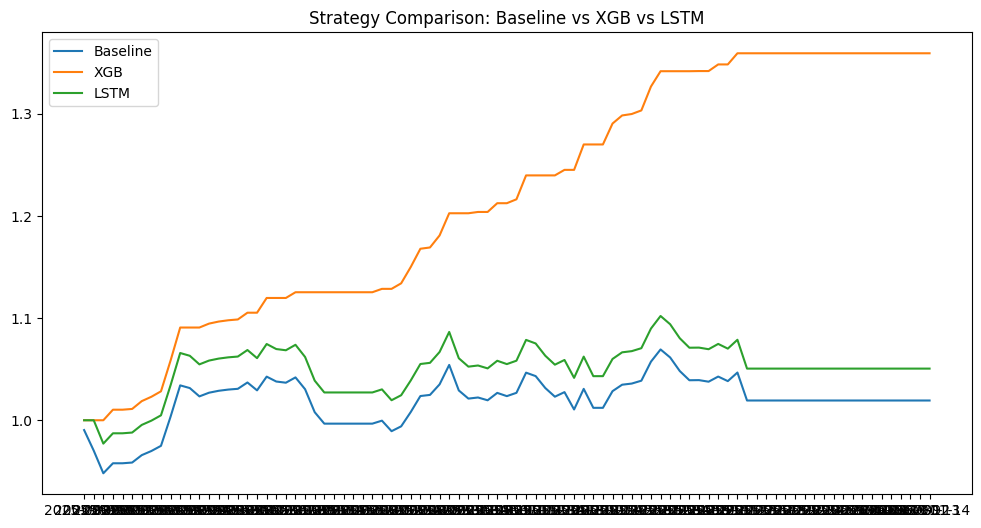

In [248]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df_bt_lstm['cum_return'], label='Baseline')
plt.plot(df_bt_lstm['xgb_cum_return'], label='XGB')
plt.plot(df_bt_lstm['lstm_cum_return'], label='LSTM')
plt.legend()
plt.title('Strategy Comparison: Baseline vs XGB vs LSTM')
plt.savefig("../plots/all_strategies_comparison.png", bbox_inches="tight")
plt.show()


In [215]:
def performance_metrics(returns):
    return {
        "Total Return (%)": round(((1 + returns).prod() - 1) * 100, 2),
        "Mean Daily Return (%)": round(returns.mean() * 100, 4),
        "Volatility (%)": round(returns.std() * 100, 4),
        "Sharpe Ratio": round(
            returns.mean() / returns.std(), 3
        ) if returns.std() != 0 else 0
    }

baseline_metrics = performance_metrics(df_bt_lstm['strategy_return'])
xgb_metrics = performance_metrics(df_bt_lstm['xgb_strategy_return'])
lstm_metrics = performance_metrics(df_bt_lstm['lstm_strategy_return'])

baseline_metrics, xgb_metrics, lstm_metrics


({'Total Return (%)': np.float64(1.93),
  'Mean Daily Return (%)': np.float64(0.0267),
  'Volatility (%)': np.float64(1.0272),
  'Sharpe Ratio': np.float64(0.026)},
 {'Total Return (%)': np.float64(35.94),
  'Mean Daily Return (%)': np.float64(0.3476),
  'Volatility (%)': np.float64(0.6556),
  'Sharpe Ratio': np.float64(0.53)},
 {'Total Return (%)': np.float64(5.06),
  'Mean Daily Return (%)': np.float64(0.0604),
  'Volatility (%)': np.float64(0.9974),
  'Sharpe Ratio': np.float64(0.061)})

## “The ML-enhanced backtest shows that the XGBoost-filtered strategy significantly outperforms both the baseline and LSTM-based strategies in terms of cumulative return and risk-adjusted performance. While the LSTM model improves upon the baseline, it does not match the consistency and profitability of the XGBoost model.”

## Save Trained Models

This section saves trained ML models to disk for reuse and reproducibility.


In [43]:
pip install xgboost


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [55]:
from xgboost import XGBClassifier

In [57]:
# Final training on full train set
gb_model.fit(X_train, y_train)


GradientBoostingClassifier(learning_rate=0.05, random_state=42)

In [61]:
import joblib
import os

MODELS_DIR = "../models"
os.makedirs(MODELS_DIR, exist_ok=True)

joblib.dump(gb_model, os.path.join(MODELS_DIR, "gradient_boosting_model.pkl"))

print("✅ Saved Gradient Boosting model to models/gradient_boosting_model.pkl")


✅ Saved Gradient Boosting model to models/gradient_boosting_model.pkl


In [63]:
# Verify saved model can be loaded
loaded_model = joblib.load("../models/gradient_boosting_model.pkl")

print("Loaded model:", type(loaded_model))
print("Test prediction sample:", loaded_model.predict(X_test[:5]))


Loaded model: <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
Test prediction sample: [1 1 0 0 0]


In [65]:
import joblib

model = joblib.load("../models/gradient_boosting_model.pkl")

print(type(model))


<class 'sklearn.ensemble._gb.GradientBoostingClassifier'>


In [67]:
model.predict(X_test[:5])


array([1, 1, 0, 0, 0])

In [218]:
from tensorflow.keras.models import load_model

loaded_lstm = load_model("../models/lstm_model.h5")
print(type(loaded_lstm))


<class 'keras.src.models.sequential.Sequential'>
